# Plot diagrams


In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
metric_file_root_path = "../runs/"
x_value_order = ["1", "3", "10", "30", "100", "All"]
x_axis_title = "N.o. samples per class"
y_axis_title = "Macro F1 score"
score_column = "f1_macro"

aggregating_configs = {
    "-Derma": "Derma",
    "-ImageNet_1k_SL_WinKawaks": "ImageNet SL",
    "-ImageNet_1k_SSL_Dino": "ImageNet SSL",
    "-ImageNet_AugReg": "ImageNet AugReg",
    "-Plant": "Plant SSL",
    "-Random": "Random",
}

architecture_configs = {
    # "-ResNet50-": "ResNet50",  #
    # "-ViT_B16-": "ViT Base",  #
    "-ViT_T16-": "ViT Tiny",  #
}
model_configs = {
    "lr": "Logistic regression",  #
    "knn": "KNN",  #
}

dataset_configs = {
    # "PAD_UFES_20-ViT_T16": "PAD-UFES-20", #
    "DDI-ViT_T16": "DDI", #
}


- PlantDoc: No prominent changes
- PlantDataset: No prominent changes
- Cassava: No prominent changes
- PlantVillage: No prominent changes
- DDI: Only tiny changes
- PAD-UFES-20: Only tiny changes
- HAM10000: No prominent changes
- Fitzpatrick17k: changes due to partition change

In [3]:
def number_to_string(value):
    if value == value:
        return str(int(value))
    else:  # NaN
        return "All"


def distribution_check(configs, column):
    total_counter = 0
    for key in configs:
        number_of_matching_rows = column.str.contains(key).sum()
        print(f"{key} -> {number_of_matching_rows} matches")
        total_counter += number_of_matching_rows

    total_length = len(column)
    if total_length != total_counter:
        print(f"{total_length} != {total_counter}")
    assert total_length == total_counter

def load_pd(dataset):
    metric_file_name = f"{dataset}-metrics.txt"
    metric_file = open(os.path.join(metric_file_root_path, metric_file_name), "r")
    content = metric_file.read().replace("\n", "").replace("}{", "},{")
    entries = json.loads("[" + content + "]")
    print(f"Read {len(entries)} entries in {metric_file_name}")
    return pd.DataFrame.from_records(entries)

Read 6012 entries in DDI-ViT_T16-metrics.txt
['../datasets/intermediate-features/DDI-ViT_T16-Derma.csv'
 '../datasets/intermediate-features/DDI-ViT_T16-ImageNet_1k_SL_WinKawaks.csv'
 '../datasets/intermediate-features/DDI-ViT_T16-ImageNet_1k_SSL_Dino.csv'
 '../datasets/intermediate-features/DDI-ViT_T16-ImageNet_AugReg.csv'
 '../datasets/intermediate-features/DDI-ViT_T16-Plant.csv'
 '../datasets/intermediate-features/DDI-ViT_T16-Random.csv']
lr -> 3006 matches
knn -> 3006 matches
DDI-ViT_T16 -> 6012 matches
-ViT_T16- -> 6012 matches
-Derma -> 1002 matches
-ImageNet_1k_SL_WinKawaks -> 1002 matches
-ImageNet_1k_SSL_Dino -> 1002 matches
-ImageNet_AugReg -> 1002 matches
-Plant -> 1002 matches
-Random -> 1002 matches


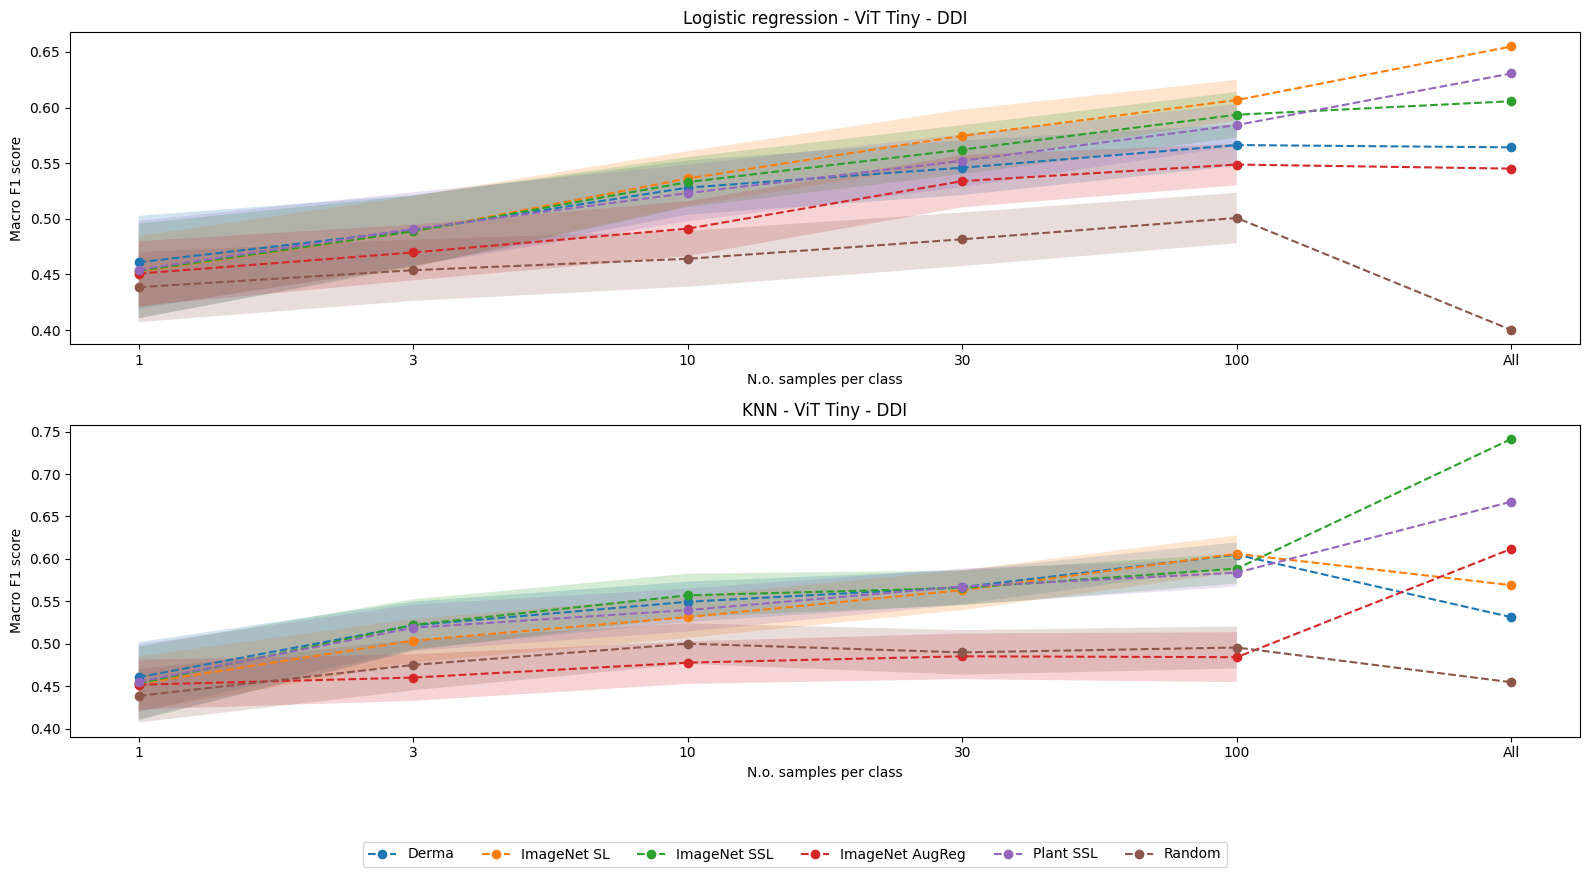

In [4]:
fig, ax = plt.subplots(
    len(architecture_configs) * len(model_configs),
    len(dataset_configs),
    figsize=(16, 8),
    squeeze=False,
)

for column, dataset_key in enumerate(dataset_configs):
    dataset_label = dataset_configs[dataset_key]
    df = load_pd(dataset_key)
    print(df["feature_identifier"].unique())

    distribution_check(model_configs, df["model_name"])
    distribution_check(dataset_configs, df["feature_identifier"])
    distribution_check(architecture_configs, df["feature_identifier"])
    distribution_check(aggregating_configs, df["feature_identifier"])

    df["number_of_samples"] = df["number_of_samples"].apply(number_to_string)
    df_data = df

    for row_1, arch_key in enumerate(architecture_configs):
        arch_label = architecture_configs[arch_key]
        df_arch = df_data[df_data["feature_identifier"].str.contains(arch_key)]

        for agg_key in aggregating_configs:
            agg_label = aggregating_configs[agg_key]
            df_agg = df_arch[
                df_arch["feature_identifier"].str.contains(agg_key)
            ]

            for row_2, model_key in enumerate(model_configs):
                model_label = model_configs[model_key]
                df_model = df_agg[
                    df_agg["model_name"].str.contains(model_key)
                ]
                row = row_1 * len(model_configs) + row_2
                df_val = df_model.groupby(["number_of_samples"]).agg(
                    {"f1_macro": ["mean", "std"]}
                )
                df_val.columns = df_val.columns.droplevel(0)
                df_val = df_val.reset_index()
                df_val.set_index("number_of_samples", inplace=True)
                df_val = df_val.reindex(index=x_value_order)

                std_err = df_val["std"] / np.sqrt(len(df_val))

                ax[row][column].fill_between(
                    df_val.index,
                    df_val["mean"] - std_err,
                    df_val["mean"] + std_err,
                    alpha=0.2,
                )
                # ax[row][column].plot(df_val["mean"], linestyle='dashed',label=label) # ,label=[label]
                df_val.plot.line(
                    ax=ax[row][column],
                    y=["mean"],
                    # x=["number_of_samples"], NOTE: index is x-axis as default
                    label=[agg_label],
                    # style=['o--']
                    marker='o',
                    linestyle='--'
                )

                # ax[row][column].set_ylim([0, 0.6])
                ax[row][column].set_title(f"{model_label} - {arch_label} - {dataset_label}")
                ax[row][column].set_ylabel(y_axis_title)
                ax[row][column].set_xlabel(x_axis_title)
                ax[row][column].get_legend().remove()
                # ax[row][column].set_xlim([xmin, xmax])
                # ax[row][column].set_ylim([0, 1])

# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines_labels = [fig.axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.tight_layout()
# fig.legend(lines, labels, loc='lower center', ncol=4)
fig.legend(
    lines, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=len(labels)
)
plt.show()

In [5]:
# df_knn = df[df["model_name"] == "knn"]
# print("Min: " + str(df_knn["best_k"].min()))
# print("Max: " + str(df_knn["best_k"].max()))
# df_knn["best_k"].plot.hist(bins=100)

# NOTE: Do not put this graphic into the report, because it is highly biased and could confuse readers

In [6]:
# x_values_random = [
#     "KNN ResNet50",
#     "KNN ResNet50",
#     "KNN ResNet50",
#     "LogReg ResNet50",
#     "LogReg ResNet50",
#     "LogReg ResNet50",
#     "KNN Swin-T",
#     "KNN Swin-T",
#     "KNN Swin-T",
#     "LogReg Swin-T",
#     "LogReg Swin-T",
#     "LogReg Swin-T",
# ]
# y_values_random = [
#     0.446064139941691,
#     0.43440233236151604,
#     0.43440233236151604,
#     0.2944606413994169,
#     0.32653061224489793,
#     0.40233236151603496,
#     0.45481049562682213,
#     0.36151603498542273,
#     0.40233236151603496,
#     0.5451895043731778,
#     0.4752186588921283,
#     0.4956268221574344,
# ]
# x_values_imagenet = [
#     "KNN ResNet50",
#     "KNN ResNet50",
#     "LogReg ResNet50",
#     "LogReg ResNet50",
#     "KNN Swin-T",
#     "LogReg Swin-T",
# ]
# y_values_imagenet = [
#     0.5714285714285714,
#     0.565597667638484,
#     0.2565597667638484,
#     0.4897959183673469,
#     0.5830903790087464,
#     0.7346938775510204,
# ]
# x_values_pddd = [
#     "KNN ResNet50",
#     "LogReg ResNet50",
#     "KNN Swin-T",
#     "LogReg Swin-T",
# ]
# y_values_pddd = [
#     0.4752186588921283,
#     0.42565597667638483,
#     0.6122448979591837,
#     0.6384839650145773,
# ]

In [7]:
# plt.scatter(x_values_random, y_values_random)
# plt.scatter(x_values_imagenet, y_values_imagenet)
# plt.scatter(x_values_pddd, y_values_pddd)
# plt.gca().set_ylabel("Accuracy")  # gca = get current axes
# plt.legend(["Random", "ImageNet", "PDDD"])
# plt.title("Cassava comparison")
# plt.show()